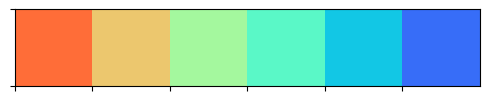

In [1]:
import os, warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import tensorflow as tf
import gc
import tensorflow.keras.backend as K

gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

import pandas as pd
from pandas import Series
import numpy as np
from joblib import Parallel, delayed
from tqdm.auto import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
import molmap.model

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette("rainbow_r", 6) #PiYG
sns.palplot(color)

from joblib import load, dump
import sklearn.metrics
import scipy
import logging

def r2_score(y_true,y_pred):
    y_mean = np.mean(y_true)
    r2 = 1-sum((y_true-y_pred)**2)/sum((y_mean-y_true)**2)
    return r2
def PCC(y_pred,y_true):
    diff_pred,diff_true=y_pred-np.mean(y_pred),y_true-np.mean(y_true)
    return np.sum(diff_pred*diff_true)/np.sqrt(np.sum(diff_pred**2)*np.sum(diff_true**2))

def from_ic50(ic50, max_ic50=50000.0):
    x = 1.0 - (np.log(np.maximum(ic50, 1e-12)) / np.log(max_ic50))
    return np.minimum(
        1.0,
        np.maximum(0.0, x))
def to_ic50(x, max_ic50=50000.0):
    return max_ic50 ** (1.0 - x)
sample_weight=None,
threshold_nm=500,
max_ic50=50000

读取 blosum62 matrix + pam250 matrix

In [2]:
blosum62 = pd.read_csv('/mnt/zt/Dopaap/dopaap_predictor/blosum_pam_data/BLOSUM62.txt', sep='\s')
blosum62 = blosum62.iloc[:-4,:-4]

pam250 = pd.read_csv('/mnt/zt/Dopaap/dopaap_predictor/blosum_pam_data/PAM250.csv',index_col=0)

将 blosum62 matrix 以及 pam250 mutation matrix 标准化到 0~1

In [3]:
# aapro归一化
PCP = pd.read_csv('/mnt/zt/Dopaap/dopaap_predictor/cal_CTD/CTD_61.csv', index_col='properties').index
AApro_dic = pd.read_csv('/mnt/zt/Dopaap/dopaap_predictor/umap/single_index/AApro_UMAP.csv', header=0,index_col=0)
AA_pro = AApro_dic.loc[PCP].astype('float')
AA_pro = AA_pro.T
AA_pro = ((AA_pro - AA_pro.min()) / (AA_pro.max() - AA_pro.min())).T #归一化

序列相关 aapro,blosum62,pam250 距离矩阵的生成与拼接

In [4]:
def get_3d_feat(seq):
    n = len(seq)

    # 生成理化性质矩阵
    seq_pro = pd.DataFrame(AA_pro[aa] for aa in seq).T
    seq_pro = seq_pro.values[:, :, None]  #二维变成三维（61， n， 1）
    ## 相乘
    mt_pro = np.transpose((seq_pro * np.transpose(seq_pro, [0, 2, 1])), [1, 2, 0])  #**.5   #here!! **0.25
    ## transpose三维转置。（61，n，1）*（61，1，n）=（61，n，n），再转置成（n，n，61）.

    # 生成blosum矩阵
    seq_blosum = np.ones((n,n))
    for i in range(n):
        a = seq[i]
        for j in range(n):
            b = seq[j]
            seq_blosum[i][j] = blosum62.loc[a,b]
    seq_blosum_nor = ((seq_blosum - seq_blosum.min()) / (seq_blosum.max() - seq_blosum.min()))
    seq_blosum_nor = seq_blosum_nor[:, :, np.newaxis]  ##（n，n，1）

    # 生成pam矩阵
    seq_pam = np.ones((n,n))
    for i in range(n):
        a = seq[i]
        for j in range(n):
            b = seq[j]
            seq_pam[i][j] = pam250.loc[a,b]
    seq_pam_nor = ((seq_pam - seq_pam.min()) / (seq_pam.max() - seq_pam.min()))
    seq_pam_nor = seq_pam_nor[:, :, np.newaxis]  ##（n，n，1）

    # 生成序列距离矩阵
    pt_dis = np.ones((n,n))
    for i in range(n):
        for j in range(n):
            pt_dis[i][j] = abs(i-j)
    pt_dis = ((pt_dis - 0) / (n-1 - 0)) ## 归一化（最小值为0，最大值为n-1）
    pt_dis = pt_dis[:, :, np.newaxis]  ##（n，n，1）

    # 改变 理化性质矩阵 的下半部分
    for k in range(mt_pro.shape[2]):
        for i in range(n):
            for j in range(i):
                if k < 60:                                      ##here
                    mt_pro[i,j,k] = (mt_pro[j,i,k] * mt_pro[j,i,k+1])**.5
                else:
                    mt_pro[i,j,k] = (mt_pro[j,i,k] * mt_pro[j,i,0])**.5

    # 将序列距离矩阵与mt合并，并放在第一层
    mt = np.concatenate((pt_dis,seq_blosum_nor,seq_pam_nor,mt_pro),axis = 2)

    x = np.pad(mt, [(0, max_seq_len-n), (0, max_seq_len-n), (0, 0)]) #填充0.令数据集中每条序列对应的Xshape相同。

    return x[ :, :, :, None]

In [5]:
class Inception(tf.keras.layers.Layer):

    def __init__(self, units = 8, strides = 1):
        super(Inception, self).__init__()
        self.conv1 = tf.keras.layers.Conv3D(units, (1,1,1), padding='same', activation = 'relu', strides = strides,kernel_regularizer=tf.keras.regularizers.l2(lamda),
  bias_regularizer=tf.keras.regularizers.l1(lamda), activity_regularizer=tf.keras.regularizers.l2(lamda))
        self.conv2 = tf.keras.layers.Conv3D(units, (3,3,3), padding='same', activation = 'relu', strides = strides,kernel_regularizer=tf.keras.regularizers.l2(lamda),
  bias_regularizer=tf.keras.regularizers.l1(lamda), activity_regularizer=tf.keras.regularizers.l2(lamda))
        self.conv3 = tf.keras.layers.Conv3D(units, (5,5,5), padding='same', activation = 'relu', strides = strides,kernel_regularizer=tf.keras.regularizers.l2(lamda),
  bias_regularizer=tf.keras.regularizers.l1(lamda), activity_regularizer=tf.keras.regularizers.l2(lamda))
        self.concat = tf.keras.layers.Concatenate()

    def call(self, inputs):
        x1 = self.conv1(inputs)
        x2 = self.conv2(inputs)
        x3 = self.conv3(inputs)
        outputs = self.concat([x1, x2, x3])
        return outputs

    def get_config(self): 
        config = {"conv1": self.conv1,"conv2":self.conv2,'conv3':self.conv3}
        base_config = super(Inception, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


In [6]:
class Model_1(tf.keras.Model):
    def __init__(self):
            super().__init__()
            
            self.Cov_1 = tf.keras.layers.Conv3D(kn_1, ks_fir, activation='relu', padding='same',kernel_regularizer=tf.keras.regularizers.l2(lamda),
    bias_regularizer=tf.keras.regularizers.l1(lamda), activity_regularizer=tf.keras.regularizers.l2(lamda))
            self.MaxPool_1 = tf.keras.layers.MaxPool3D() #pool_size = (2,2,2)
    #         #here
    #         tf.keras.layers.Conv3D(kn_1, (5,5,5), activation='relu', padding='same',kernel_regularizer=tf.keras.regularizers.l2(lamda),
    # bias_regularizer=tf.keras.regularizers.l1(lamda), activity_regularizer=tf.keras.regularizers.l2(lamda)),
    #         tf.keras.layers.MaxPool3D(), #pool_size = (2,2,2)
    #         #here
            self.Cov_2 =Inception(units=kn_2, strides=1)
            self.MaxPool_2 = tf.keras.layers.MaxPool3D()
            self.Cov_3 = Inception(units=kn_3, strides=1)
            self.GlobalMaxPool = tf.keras.layers.GlobalMaxPooling3D()         #tf.keras.layers.Flatten(),
            self.Dense_1 = tf.keras.layers.Dense(128, activation='relu')
            self.Dense_2 =tf.keras.layers.Dense(32, activation='relu')
            self.Dense_3 =tf.keras.layers.Dense(1)
    
    def call(self, input):
            x = self.Cov_1(input)
            x = self.MaxPool_1(x)
            x = self.Cov_2(x) 
            x = self.MaxPool_2(x)
            x = self.Cov_3(x)
            x = self.GlobalMaxPool(x)
            x = self.Dense_1(x)
            x = self.Dense_2(x)
            x = self.Dense_3(x)
            return x

In [7]:
class Model_2(tf.keras.Model):
    def __init__(self):
            super().__init__()
            
            self.Cov_1 = tf.keras.layers.Conv3D(kn_1, ks_fir, activation='relu', padding='same',kernel_regularizer=tf.keras.regularizers.l2(lamda),
    bias_regularizer=tf.keras.regularizers.l1(lamda), activity_regularizer=tf.keras.regularizers.l2(lamda))
            self.MaxPool_1 = tf.keras.layers.MaxPool3D() #pool_size = (2,2,2)
            #here
            self.Cov_2 = tf.keras.layers.Conv3D(kn_1, (5,5,5), activation='relu', padding='same',kernel_regularizer=tf.keras.regularizers.l2(lamda),
    bias_regularizer=tf.keras.regularizers.l1(lamda), activity_regularizer=tf.keras.regularizers.l2(lamda))
            self.MaxPool_2 = tf.keras.layers.MaxPool3D() #pool_size = (2,2,2)
            #here
            self.Cov_3 =Inception(units=kn_2, strides=1)
            self.MaxPool_3 = tf.keras.layers.MaxPool3D()
            self.Cov_4 = Inception(units=kn_3, strides=1)
            self.GlobalMaxPool = tf.keras.layers.GlobalMaxPooling3D()         #tf.keras.layers.Flatten(),
            self.Dense_1 = tf.keras.layers.Dense(128, activation='relu')
            self.Dense_2 =tf.keras.layers.Dense(32, activation='relu')
            self.Dense_3 =tf.keras.layers.Dense(1)
            
    
    def call(self, input):
            x = self.Cov_1(input)
            x = self.MaxPool_1(x)
            #here
            x = self.Cov_2(x)
            x = self.MaxPool_2(x)
            #here
            x = self.Cov_3(x) 
            x = self.MaxPool_3(x)
            x = self.Cov_4(x)
            x = self.GlobalMaxPool(x)
            x = self.Dense_1(x)
            x = self.Dense_2(x)
            x = self.Dense_3(x)
            return x

从MHCflurry训练验证集提取出可使用的数据集。allele['HLA-B_2704','HLA-B_2706','HLA-B_3801']

训练模型

In [9]:
import gc
class_name = 'class_1'                                                     #here!
# Train_dir = '/raid/hly/PK-3[2018PLOS]/data/train_data-MID/'+ class_name +'_pre'     
Train_dir = '/raid/hly/PK-4[MHCflurry]/no_mass_spec/data/trainval_MID_otherAllele'
Test_dir = '/mnt/zt/Dopaap/dopaap_predictor/dopaap_sota_model_on_plos_test/test_data'
loss_models_results_dir = '/mnt/zt/Dopaap/dopaap_predictor/PK-3_2018PLOS_from_hly_vaccin_task/loss_models_results'



for allele in os.listdir(Test_dir):
    
    print(f'{allele} is processing...')
    
    if allele not in os.listdir(loss_models_results_dir):
        continue
    print(f'{allele} is starting...')
    
    df_test = pd.read_csv(os.path.join(Test_dir, allele, 'Plos_peptide_allele_prediction.csv'))  
    
    # 创建储存 Allele 结果的文件夹
    task_dir = loss_models_results_dir             
    Allele_fold = os.path.join(loss_models_results_dir, allele)

    if not os.path.exists(Allele_fold) : 
        os.makedirs(Allele_fold)
        os.makedirs(os.path.join(Allele_fold,'loss'))
        os.makedirs(os.path.join(Allele_fold,'models'))
        os.makedirs(os.path.join(Allele_fold,'results'))
        # os.makedirs(os.path.join(Allele_fold,'fig-loss'))
        # os.makedirs(os.path.join(Allele_fold,'fig-pfm'))
        # os.makedirs(os.path.join(Allele_fold,'fig-pred_true')) 

    # 获得训练集和测试集的最大序列长度
    max_seq_len = df_test['Description'].apply(len).max()

    X_test_data_dir = '/mnt/zt/Dopaap/dopaap_predictor/PK-3_2018PLOS_from_hly_vaccin_task/X_test_data'

    # 生成 X_test + Y_test 
    X_test_name = os.path.join(X_test_data_dir, allele+'_X_test_'+'.data')
    if not os.path.exists(X_test_name) :
        X_test = []
        for seq in df_test['Description']:
            X_test.append(get_3d_feat(seq))
        X_test = np.stack(X_test)
        dump(X_test, X_test_name)
    else:
        X_test = load(X_test_name)
    X_test = X_test.astype('float32')
    Y_test = df_test['Normalized_QM'].values.reshape(-1, 1) 

    # 确定参数和模型
    task_name = allele +'_noMS'
    
    df_res = pd.read_csv(os.path.join(Allele_fold,'results', task_name +'_results.csv'))
    
    # 參數
    inc = df_res['kernel_size_incept'][0]
    inc = eval(inc)
    lr = df_res['lr'][0]
    ks_fir = df_res['kernel_size_1'][0]
    ks_fir = eval(ks_fir)
    kn = df_res['kernel_number'][0]
    kn = eval(kn)
    kn_1,kn_2,kn_3 = kn[0],kn[1],kn[2]
    lamda = df_res['lamda'][0]
    bs = df_res['batch_size'][0]
    
    if allele in ['HLA-A_0201','HLA-A_3002','HLA-A_0203',
        'HLA-B_2705','HLA-A_0301','HLA-B_5301','HLA-A_6802','HLA-A_3301']:   
        model = Model_2()
    else:
        model = Model_1()
        
    X = load(X_test_name)
    model.build(X.shape)
    model.load_weights(os.path.join(Allele_fold, 'models', task_name +'_model_.h5'))
    

    # make prediction
    Y_test_pred = model.predict(X_test)
    df_pred = pd.DataFrame(Y_test_pred).rename(columns={0:'Dopaap_IC50_Normalized_find_sota_in_part2'})
    df_combined = pd.concat([df_test, df_pred], axis=1)
    df_combined.to_csv(os.path.join(Test_dir, allele, 'dopaap_prediction.csv'), index=False)
    
    # 删除model
    del model
    # Perform garbage collection
    gc.collect()
    print(f'{allele} is over...')

HLA-A_0202 is processing...
HLA-A_0202 is starting...
5/5 [==============================] - 0s 4ms/step
HLA-A_0202 is over...
HLA-A_0206 is processing...
HLA-A_0206 is starting...


ValueError: Cannot assign value to variable ' dense_9/kernel:0': Shape mismatch.The variable shape (192, 128), and the assigned value shape (192, 512) are incompatible.

In [12]:
allele
gc.collect()

2684